In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import joblib


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set dataset path
dataset_path = "/content/drive/MyDrive/MP_AUTISM/Handwriting"

# Define classes
classes = ['ASD_Mild', 'ASD_Moderate', 'ASD_Severe', 'Non_ASD']

In [4]:
# Function to load images and labels from a specific folder
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            # Read image
            img = cv2.imread(img_path)
            if img is None:
                continue
            # Image enhancement:
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Histogram equalization
            gray_eq = cv2.equalizeHist(gray)
            # Resize to CNN input size
            resized = cv2.resize(gray_eq, (224, 224))
            # Convert to 3-channel RGB
            rgb_img = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
            images.append(rgb_img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return images, labels


In [5]:
# Load training data
X_train_list = []
y_train_list = []

for cls in classes:
    train_folder = os.path.join(dataset_path, 'Train', cls)
    imgs, lbls = load_images_from_folder(train_folder, cls)
    X_train_list.extend(imgs)
    y_train_list.extend(lbls)

# Load test data
X_test_list = []
y_test_list = []

for cls in classes:
    test_folder = os.path.join(dataset_path, 'Test', cls)
    imgs, lbls = load_images_from_folder(test_folder, cls)
    X_test_list.extend(imgs)
    y_test_list.extend(lbls)

# Load validation data
X_valid_list = []
y_valid_list = []

for cls in classes:
    valid_folder = os.path.join(dataset_path, 'Valid', cls)
    imgs, lbls = load_images_from_folder(valid_folder, cls)
    X_valid_list.extend(imgs)
    y_valid_list.extend(lbls)

In [6]:
# Convert to numpy arrays
X_train = np.array(X_train_list)
X_test = np.array(X_test_list)
X_valid = np.array(X_valid_list)

y_train = np.array(y_train_list)
y_test = np.array(y_test_list)
y_valid = np.array(y_valid_list)


In [7]:
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_valid_enc = le.transform(y_valid)


In [8]:
# Load pretrained ResNet50 model (without top classifier)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
# Function to extract features
def extract_features(images):
    images_preprocessed = preprocess_input(images)
    features = base_model.predict(images_preprocessed, verbose=1)
    return features.reshape(features.shape[0], -1)

print("Extracting features from training data...")
X_train_feats = extract_features(X_train)

print("Extracting features from test data...")
X_test_feats = extract_features(X_test)

print("Extracting features from validation data...")
X_valid_feats = extract_features(X_valid)

Extracting features from training data...
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step
Extracting features from test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Extracting features from validation data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [10]:
# Train SVM classifier
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train_feats, y_train_enc)

SVC(kernel='linear', probability=True)

In [11]:
# Save the trained model
joblib.dump(svm_clf, '/content/drive/MyDrive/MP_AUTISM/Handwriting_Resnet_SVM.pkl')

['/content/drive/MyDrive/MP_AUTISM/Handwriting_Resnet_SVM.pkl']

In [12]:
# Predict on test data
y_pred = svm_clf.predict(X_test_feats)

In [13]:
y_valid_pred = svm_clf.predict(X_valid_feats)

In [14]:
# Evaluate
print("Test Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Test Report:
              precision    recall  f1-score   support

    ASD_Mild       0.75      1.00      0.86         6
ASD_Moderate       1.00      0.67      0.80         6
  ASD_Severe       1.00      1.00      1.00         6
     Non_ASD       1.00      1.00      1.00         5

    accuracy                           0.91        23
   macro avg       0.94      0.92      0.91        23
weighted avg       0.93      0.91      0.91        23



In [15]:
print("Validation  Report:")
print(classification_report(y_valid_enc, y_valid_pred, target_names=le.classes_))

Validation  Report:
              precision    recall  f1-score   support

    ASD_Mild       0.91      0.83      0.87        12
ASD_Moderate       1.00      0.75      0.86        12
  ASD_Severe       0.92      1.00      0.96        12
     Non_ASD       0.79      1.00      0.88        11

    accuracy                           0.89        47
   macro avg       0.90      0.90      0.89        47
weighted avg       0.91      0.89      0.89        47



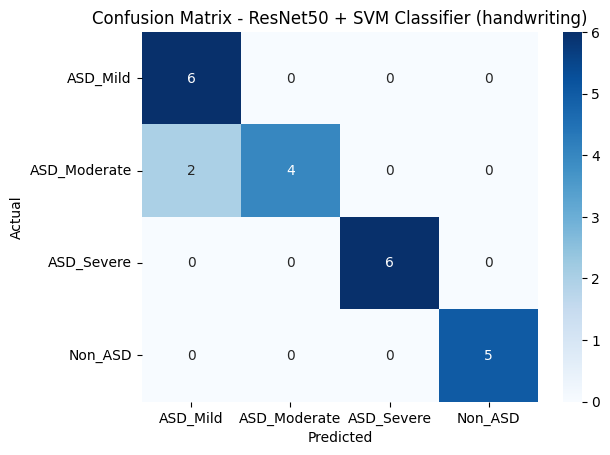

In [27]:
# Plot confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test_enc, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ResNet50 + SVM Classifier (handwriting)')
plt.show()


# Grad-CAM Gradient-weighted Class Activation Mapping

In [18]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [19]:
# Identify the last convolutional layer
last_conv_layer_name = 'conv5_block3_out'  # For ResNet50

In [20]:
# Create a model that outputs the last conv layer and predictions
grad_model = tf.keras.models.Model(
    [base_model.inputs],
    [base_model.get_layer(last_conv_layer_name).output, base_model.output]
)

In [21]:
def make_gradcam_heatmap(img_array, class_idx):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Compute guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # ReLU
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

In [22]:
def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, alpha, cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 1 - alpha, 0)
    return overlay


In [23]:
# Example: pick a test image
idx = 0  # change index for different images
img = X_test[idx]
# Preprocess image for EfficientNet
img_input = np.expand_dims(img, axis=0)
img_input = preprocess_input(img_input)

In [24]:
# Get model predictions
preds = svm_clf.predict(X_test_feats[idx].reshape(1, -1))
pred_class_idx = preds[0]
pred_class_label = le.inverse_transform([pred_class_idx])[0]

In [25]:
# Generate heatmap
heatmap = make_gradcam_heatmap(img_input, pred_class_idx)

# Overlay heatmap
overlay_img = overlay_heatmap_on_image(img, heatmap)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


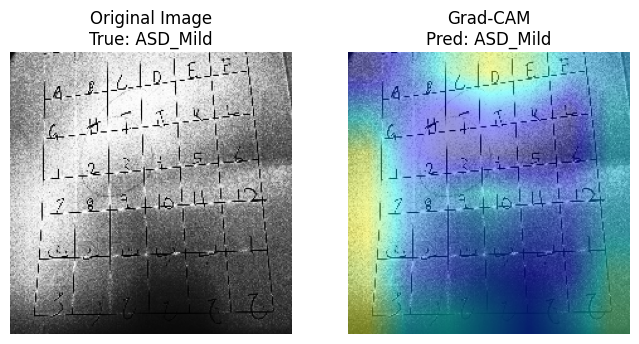

In [26]:
# Plot
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title(f"Original Image\nTrue: {y_test[idx]}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM\nPred: {pred_class_label}")
plt.imshow(overlay_img)
plt.axis('off')

plt.show()